# Frustration and Spin Ice
### Christina Lee
### Category: Prerequisites
### Prerequisites: Monte Carlo Ferromagnet, Phase Transitions, Statistical Mechanics


        name::String
        l::Int16
        dim::Int8
        a::Array
        unit::Array
        N::Int16
        X::Array
        nnei::Int8
        neigh::Array
        

Load our packages.  

`Lattices.jl` is the same class I used in the previous post.  Well, I got around to updating the Julia syntax.  So mostly the same.

In [3]:
push!(LOAD_PATH,".")
using Lattices;
using Statistics
using Plots
gr()

Plots.GRBackend()

Here we set up our lattice.

In [4]:
## Define l here
l=10;

lt=MakeLattice("Checkerboard",l);
S=ones(Int8,l,l);  #Our spins

In [5]:
for ii in 1:l
    for jj in 1:l
        S[ii,jj]=(-1)^ii * (-1)^jj
    end
end
dt=1/(lt.N);

In [216]:
colors=[colorant"#dc322f",:black,colorant"#268bd2"]
sq_cl=[colorant"#002b36",colorant"#657b83",colorant"#fdf6e3"]

lo2=Int(l/2) # l over 2

v1=[(-.5,-1.5),(-1.5,-.5),
    (-0.5,0.5),(-1.,1.),(.75,.75),(1.,-1.),(0.5,-0.5)]
v2=[(.5,-1.5),(1.5,-.5),
    (0.5,0.5),(1.,1.),(-.75,.75),(-1,-1),(-.5,-.5)]
v3=[(-.5,1.5),(-1.5,.5),
    (-0.5,-0.5),(-1.,-1.),(.75,-.75),(1.,1.),(0.5,0.5)]
v4=[(.5,1.5),(1.5,.5),
    (0.5,-0.5),(1,-1),(-.75,-.75),(-1.,1.),(-.5,.5)]

vs1=repeat([Shape(v1),Shape(v2)],lo2)
vs2=repeat([Shape(v3),Shape(v4)],lo2)
arrows=repeat([vs1; vs2],lo2)


sqA=collect(1.5:2:l)
x_sqA=repeat(sqA,1,lo2)[:]; 
y_sqA=transpose(repeat(sqA,1,lo2 ))[:];

sqB=collect(.5:2:l)
x_sqB=repeat(sqB,1,lo2 )[:];
y_sqB=transpose(repeat(sqB,1,lo2 ) )[:];

In [2]:
function Arrow_dir(ii,S,l)
    ni=floor(Int,ii/l)
    mi=mod(ii,l)
    
    v1=Shape([(-.5,-1.5),(-1.5,-.5),
        (-0.5,0.5),(-1.,1.),(.75,.75),(1.,-1.),(0.5,-0.5)])
    v2=Shape([(.5,-1.5),(1.5,-.5),
        (0.5,0.5),(1.,1.),(-.75,.75),(-1,-1),(-.5,-.5)])
    v3=Shape([(-.5,1.5),(-1.5,.5),
        (-0.5,-0.5),(-1.,-1.),(.75,-.75),(1.,1.),(0.5,0.5)])
    v4=Shape([(.5,1.5),(1.5,.5),
        (0.5,-0.5),(1,-1),(-.75,-.75),(-1.,1.),(-.5,.5)])
    
    if iseven(ni) 
        if iseven(mi) # pos 1
            if S==1
                return v1
            else 
                return v4
            end
        else # pos 2
            if S==1 
                return v2
            else
                return v3
            end
        end
    else
        if iseven(mi) # pos 3
            if S==1
                return v3
            else
                return v2
            end
        else # pos 4
            if S==1
                return v4
            else
                return v1
            end
        end
    end
end    

Arrow_dir (generic function with 1 method)

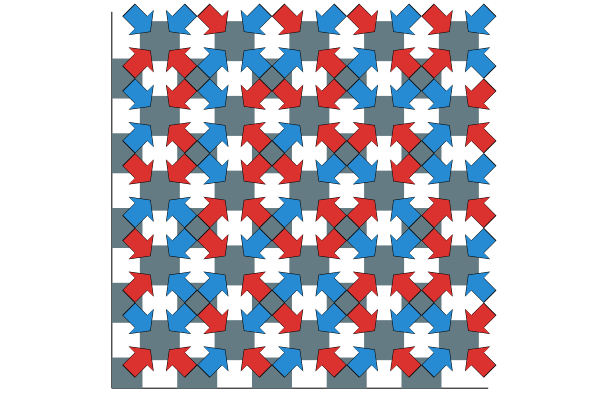

In [217]:
msize=20

scatter([x_sqA; x_sqB],[y_sqA; y_sqB],
    color=sq_cl[sign.([monopolesA; -monopolesB]).+2],
    markersize=msize,markershape=:square,markerstrokewidth=0)

scatter!(lt.X[:,1],lt.X[:,2],color=colors[S[:].+2],
    markershape=arrows,markersize=msize)

plot!(legend=false,grid = false,
    xticks = nothing, yticks = nothing,aspect_ratio=1)

In [1]:
iseven(2)

true

Same as last time.  

These functions calculate properties of our lattice.

In [51]:
# The energy contribution of just one site
function dE(i::Int)
    Eii=0;
    for j in 1:lt.nnei
        Eii+=S[lt.neigh[i,j]];
    end
    Eii*=-J*S[i];  # we are computing J sz_i sz_j for one i
    return Eii;
end
# The energy of the entire lattice
function E()
    Evar=0;
    for k in 1:lt.N
        Evar+=.5*dE(k);
    end
    return Evar;
end
# The magnetization of the entire lattice
function M()
    Mvar=0;
    for k in 1:lt.N
        Mvar+=S[k];
    end
    return Mvar;
end
"defined functions"

"defined functions"

7.888609052210118e-31

### Adjustable Parameters

In [53]:
beta=1;

J=-1;
t=10000;
nskip=10;   # don't measure every sweep= better decorrelation
"Parameters set"

"Parameters set"

In [54]:
nmeas=Int64(t/nskip); # how many times we will measure
"done"

"done"

I took what we ran last time and wrapped it into a function, `MCMCMagnet`.  We aren't looking at spin configurations this time; we only want the final measureables, which get returned at the end.

In [151]:
function MCMCMagnet(beta::Float64)
    tm=1; #Our measurement time step
    
    Ma=Array{Int32}(undef,nmeas); # our magnetization measurements
    Ea=Array{Int32}(undef,nmeas); # our energy measurements
    Ma2=Array{Int32}(undef,nmeas); # magnetization squared
    Ea2=Array{Int32}(undef,nmeas); # energy squared
    
    for ti in 1:t
        for j in 1:lt.N
            i = rand(1:lt.N); #Choosing a random site
            de=dE(i);
            if(de>0 || rand()<exp(2*beta*de) ) 
                S[i]=-S[i]; #Switch the sign
            end
        end
        if isapprox(mod(ti,nskip),0)
            Ma[tm]=M()
            Ma2[tm]=Ma[tm]^2
            
            Ea[tm]=E()
            Ea2[tm]=Ea[tm]^2
            
            tm+=1

        end
    end
    Mave=mean(Ma);
    Mstd=std(Ma)/lt.N;
    Eave=mean(Ea);
    Estd=std(Ea)/lt.N;
    
    E2ave=mean(Ea2);
    M2ave=mean(Ma2);

    
    Ch=beta^2*(E2ave-Eave^2)/lt.N;
    χ=beta*(M2ave-Mave^2)/lt.N;
    
    return Mave/lt.N,Mstd,Eave/lt.N,Estd,Ch,χ
end

MCMCMagnet (generic function with 1 method)

In [152]:
MCMCMagnet(1.0)

(0.00196, 0.028414182475759622, -0.85752, 0.04989126916343919, 0.2486649600000055, 0.08065583999999999)

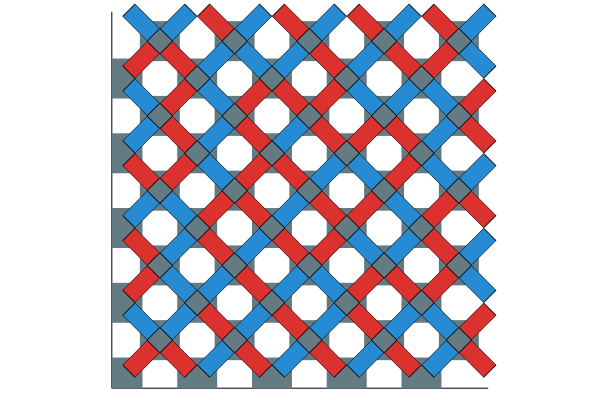

In [153]:
msize=20

scatter([x_sqA; x_sqB],[y_sqA; y_sqB],
    color=sq_cl[sign.([monopolesA; -monopolesB]).+2],
    markersize=msize,markershape=:square,markerstrokewidth=0)

scatter!(lt.X[ind1,1],lt.X[ind1,2],color=colors[S[ind1].+2],
    markershape=Shape(v2),markersize=msize)
scatter!(lt.X[ind2,1],lt.X[ind2,2],color=colors[S[ind2].+2],
    markershape=Shape(v1),markersize=msize)

plot!(legend=false,grid = false,
    xticks = nothing, yticks = nothing,aspect_ratio=1)

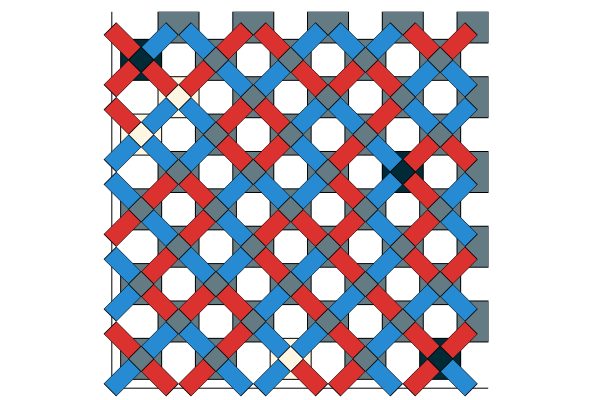

In [123]:
msize=20

scatter(x_sqA,y_sqA,
    color=sq_cl[sign.(monopolesA).+2],
    markersize=msize,markershape=:square)

scatter!(x_sqB,y_sqB,
    color=sq_cl[sign.(monopolesB).+2],
    markersize=msize,markershape=:square)

scatter!(lt.X[ind1,1],lt.X[ind1,2],color=colors[S[ind1].+2],
    markershape=Shape(v2),markersize=msize)
scatter!(lt.X[ind2,1],lt.X[ind2,2],color=colors[S[ind2].+2],
    markershape=Shape(v1),markersize=msize)

plot!(legend=false,grid = false,
    xticks = nothing, yticks = nothing,aspect_ratio=1)

In [125]:
BTetii(1,l)

4-element Array{Int64,1}:
   1
  10
  91
 100

In [147]:
monopolesA=zeros(Int,lo2^2)
monopolesB=zeros(Int,lo2^2)
for jj in 1:lo2^2
    for ii in ATetii(jj,l)
        monopolesA[jj]+=S[ii]
    end
    for ii in BTetii(jj,l)
        monopolesB[jj]+=S[ii]
    end
end
monopolesB

25-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [84]:
function toATet(ii::Int,l)
    ni=ceil(Int,ii/(2*l))
    mi=ceil(Int,(mod(ii-1,l)+1)/2)
    
    return round(Int,(l/2)*(ni-1)+mi)
end

function toBTet(ii::Int)
    ni=round(Int, mod(ceil(Int,ii/(2l)+.5)-1,(l/2))+1 )
    mi=floor(Int,(mod(ii,l))/2)+1
    
    return round(Int,(l/2)*(ni-1)+mi)
end  

function ATetii(jj::Int,l)
    nj=ceil(Int, 2*jj/(l) )
    mj=floor(Int, mod(jj-1,l/2) )+1
    
    jj1=2*l*(nj-1)+2*(mj-1)+1
    jj2=2*l*(nj-1)+2*(mj-1)+2
    jj3=2*l*(nj-1)+2*(mj-1)+1+l
    jj4=2*l*(nj-1)+2*(mj-1)+2+l
    
    return [jj1, jj2, jj3, jj4]
end

function BTetii(jj::Int,l)
    nj=ceil(Int, 2*jj/l )
    mj=floor(Int, mod(jj-1,l/2) )+1
    
    jj1=2*l*(nj-1)+2*(mj-1)+1
    jj2=mod(2*(mj-1)-1,l)+1+2*l*(nj-1)
    jj3=round(Int, 2*l*mod((nj-2),l/2)+l+    2*(mj-1)+1 )
    jj4=round(Int, 2*l*mod((nj-2),l/2)+l+    mod(2*(mj-1)-1,l)+1 )
    
    return [jj1, jj2, jj3,jj4]
end

BTetii (generic function with 2 methods)

In [18]:
dbeta=betas[2:end]-betas[1:end-1]
dbeta=[dbeta[1]; dbeta]
dS=- Ch .* dbeta ./(betas)
S=zeros(length(betas))
for ii in 1:length(betas)
    S[ii]=sum(dS[1:ii])
end

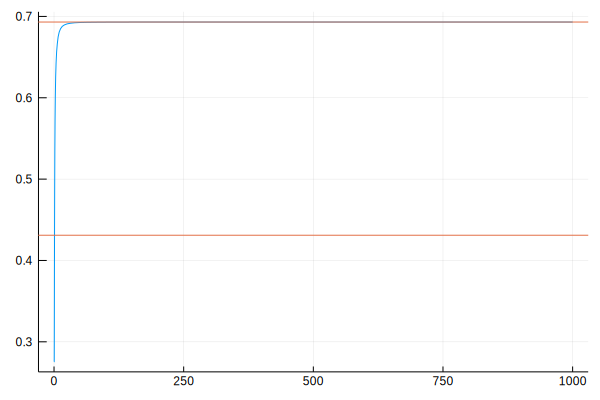

In [19]:
plot(1.0 ./betas,S.+log(2) )
hline!([log(2),.431])

plot!(legend=:false)

### Storing and Restoring Data

Since running these simulations take slightly longer than some of my previous posts, I've outputed data files of the results of three different sizes lattices (l=10, l=20, l=50), for runs of length 100,000.  All have the same `betas` variable. Feel free to take a look at them, or make your own data :)

In [ ]:
writedlm(string("SpinIceL",l,"t",t,".dat"),[betas Mm Mstd Ee Estd Ch χ])

In [ ]:
temp=readdlm("SpinIceL50t100000.dat")
betas=temp[:,1];
Mm50=temp[:,2];
Mstd50=temp[:,3];
Ee50=temp[:,4];
Estd50=temp[:,5];
Ch50=temp[:,6];
χ50=temp[:,7];

temp=readdlm("SpinIceL10t100000.dat")
Mm10=temp[:,2];
Mstd10=temp[:,3];
Ee10=temp[:,4];
Estd10=temp[:,5];
Ch10=temp[:,6];
χ10=temp[:,7];

temp=readdlm("SpinIceL20t100000.dat")
Mm20=temp[:,2];
Mstd20=temp[:,3];
Ee20=temp[:,4];
Estd20=temp[:,5];
Ch20=temp[:,6];
χ20=temp[:,7];

# Plotting Section

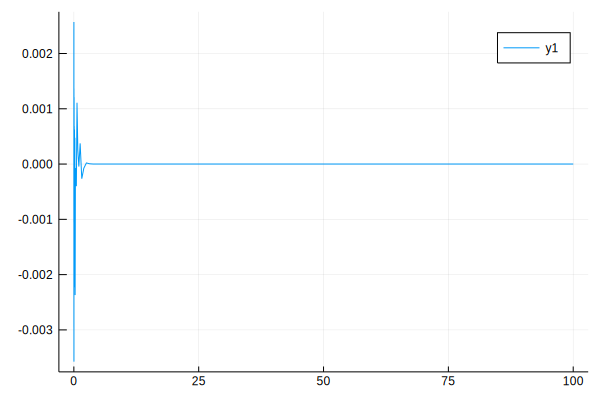

In [20]:
plot(betas,Mm)

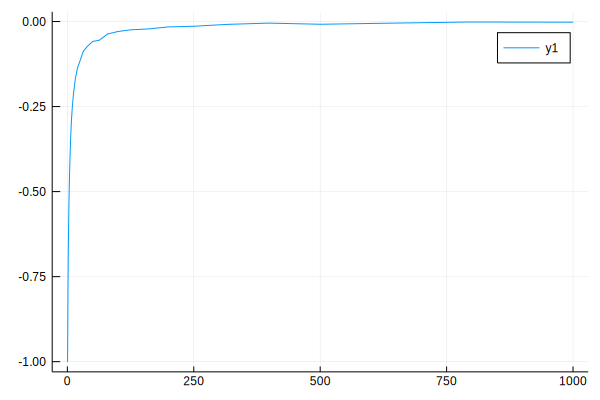

In [23]:
plot(1.0 ./betas,Ee)

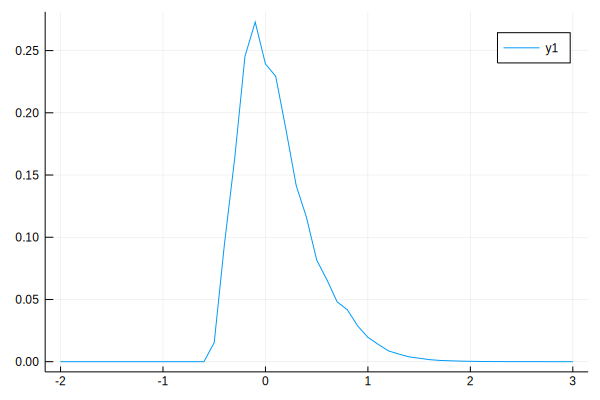

In [28]:
plot(log10.(1.0 ./betas),Ch )

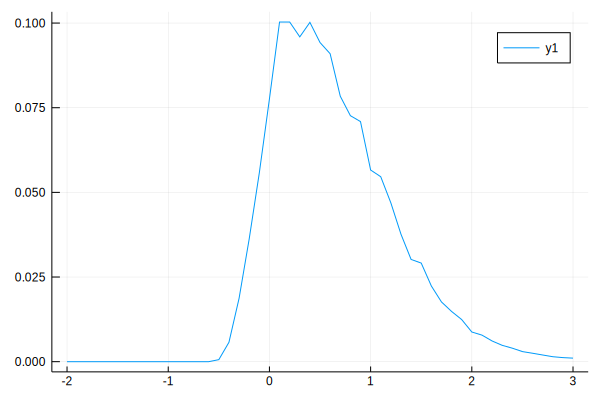

In [29]:
plot(log10.(1.0 ./betas),χ)

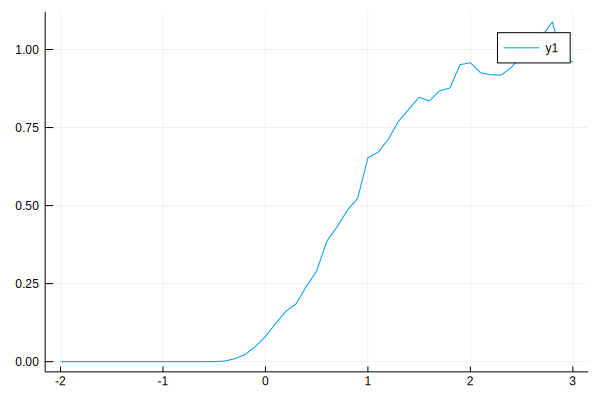

In [125]:
## need to calculate direction of spin
plot(log10.(1.0 ./betas),χ2D./betas)